In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, IceCreamHeaterDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [15]:
# Read a pandas DataFrame
df = pd.read_csv("GlobalTemperatures.csv", delimiter=",")

# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, "dt", "LandAverageTemperature")

# 创建一个从20160101到21001201，每月的时间序列
pred = TimeSeries.from_times_and_values(pd.date_range('17500101', '21001201', freq='M'), np.random.randn(4211))

series = series.astype(np.float32)

transformer = Scaler()
train_transformed = transformer.fit_transform(series)
series_transformed = transformer.transform(series)



# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(pred, attribute="year", one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(pred, attribute="month", one_hot=False)
)
covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=pred.time_index,
        values=np.arange(len(pred)),
        columns=["linear_increase"],
    )
)
covariates = covariates.astype(np.float32)
training_cutoff = pd.Timestamp("20151201")
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [11]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=16,
    n_epochs=300,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

In [ ]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

In [36]:
my_model.save("my_model.pt")

In [ ]:
# before starting, we define some constant
pred_series = my_model.predict(n=12)
print(pred_series)

In [26]:
backtest_series = my_model.historical_forecasts(
    series,
    future_covariates=covariates,
    start=series.end_time() - 120*series.freq,
    num_samples=200,
    forecast_horizon=forecast_horizon,
    stride=forecast_horizon,
    last_points_only=False,
    retrain=False,
    verbose=True,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

Predicting: 198it [00:00, ?it/s]

In [ ]:
transformer = Scaler()
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"
def eval_backtest(backtest_series, actual_series, horizon, start, transformer):
    plt.figure(figsize=figsize)
    actual_series.plot(label="actual")
    backtest_series.plot(
        low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
    )
    backtest_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)
    plt.legend()
    plt.title(f"Backtest, starting {start}, {horizon}-months horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                actual_series,
                backtest_series,
            )
        )
    )


eval_backtest(
    backtest_series=concatenate(backtest_series),
    actual_series=series,
    horizon=forecast_horizon,
    start=series.end_time() - 120*series.freq,
    transformer=transformer,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 3it [00:00, ?it/s]

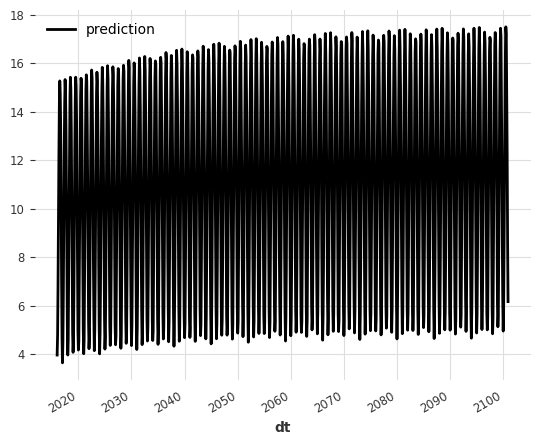

In [35]:
pred = my_model.predict(n=12*(100-15))
pred.plot(label="prediction")

In [39]:
# 将pred转换为dataframe
pred_df = pred.pd_dataframe()
pred_df['dt'] = pd.date_range(start='2016-01-01', periods=1020, freq='MS')

In [47]:
# 使用plotly绘制预测结果
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['dt'][-12:], y=df['LandAverageTemperature'][-12:], name='actual'))
fig.add_trace(go.Scatter(x=pred_df['dt'], y=pred_df['LandAverageTemperature'], name='prediction'))
# 20摄氏度的水平线
fig.add_shape(type="line", x0="2014-01-01", y0=20, x1="2100-12-01", y1=20, line=dict(color="Red", width=2))
fig.update_layout(title="TFT", xaxis_title="Date", yaxis_title="Temperature")
fig.show()

In [53]:
my_model.load("my_model.pt")

  0%|          | 0/38 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

Predicting: 2it [00:00, ?it/s]

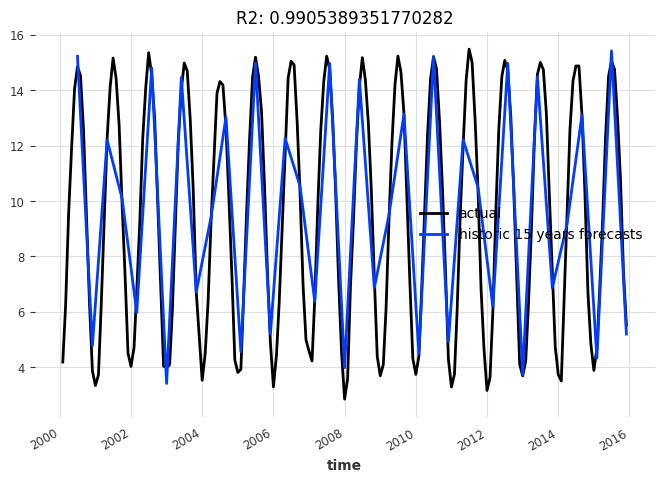

In [54]:
train, val = series.split_after(pd.Timestamp("20000101"))
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()
pred_series = my_model.historical_forecasts(
    series,
    start=pd.Timestamp("20000101"),
    forecast_horizon=7,
    stride=5,
    retrain=False,
    verbose=True,
)
display_forecast(pred_series, series, "15 years", start_date=pd.Timestamp("20000101"))

In [ ]:
# 使用plotly绘制预测结果
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['dt'][-12:], y=df['LandAverageTemperature'][-12:], name='actual'))
fig.add_trace(go.Scatter(x=pred_df['dt'], y=pred_df['LandAverageTemperature'], name='prediction'))